## 1. Find the correct map to read sleep stages

In [1]:
import xmltodict
import numpy as np
import pandas as pd

# Initial variable 
mastersheet_path = "/Users/alicealbrecht/Desktop/UCSF/pipeline_project/datasets/mastersheets/mros_ses02_mastersheet.csv"
mastersheet = pd.read_csv(mastersheet_path)
row = mastersheet.iloc[1]
annot_path = row["annot_path"]
start_time = row["start_time"]
sfreq_global = row["sfreq_global"]
duration_sec = row["duration_sec"]

# Open and read xml 
with open(annot_path, encoding='utf-8') as f:
        info_dict = xmltodict.parse(f.read())

# Sleep stage  
raw_stages = info_dict['CMPStudyConfig']['SleepStages']['SleepStage']
stage_dict = {'0':0, '1':1, '2':2, '3':3, '4':3, '5':4}  
full_sleep_stages = [stage_dict.get(str(s), np.nan) for s in raw_stages]

# Get the number of epochs
duration_sec = mastersheet.iloc[1]["duration_sec"]
epoch_size_sec = float(info_dict['CMPStudyConfig']['EpochLength'])
n_epochs = int(duration_sec / epoch_size_sec)
print(f"Check: {n_epochs} = {len(full_sleep_stages)}")
print(start_time)

Check: 1830 = 1830
2011-07-06 20:38:46+00:00


In [2]:
onset = np.arange(0, n_epochs * 30, 30)
duration = np.full(n_epochs, 30)

# Create DataFrame
df_stages = pd.DataFrame({
    'onset': onset,
    'duration': duration,
    'sleep_stage': full_sleep_stages 
})

df_stages

,onset,duration,sleep_stage
0,0,30,0.0
1,30,30,0.0
2,60,30,0.0
3,90,30,0.0
4,120,30,0.0
...,...,...,...
1825,54750,30,0.0
1826,54780,30,0.0
1827,54810,30,0.0
1828,54840,30,0.0


## (Optional) Ploting hypnogram to check the mapping 

/var/folders/nk/ctx5v5kd62l2xk1gz7kgm5vr0000gn/T/ipykernel_54562/3307974463.py:12: RuntimeWarning: invalid value encountered in cast
  sleep_stages = np.array(full_sleep_stages).astype(int)  # ensure int


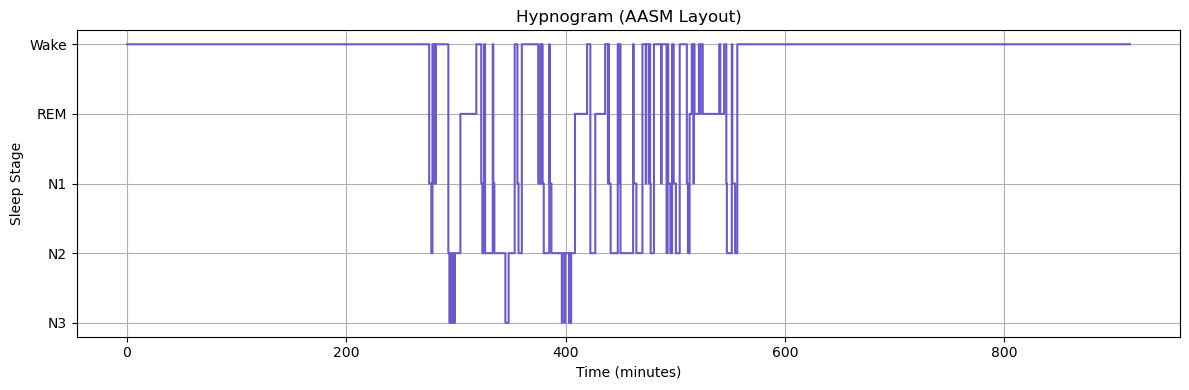

In [3]:
import matplotlib.pyplot as plt

# Invert the hypnogram so Wake is at top
epoch_stages = np.array(full_sleep_stages, dtype=float)
time_axis = np.arange(len(epoch_stages)) * epoch_size_sec / 60  # in minutes

# Mapping from sleep stage to plot y-position
plot_order = {0: 0, 4: 1, 1: 2, 2: 3, 3: 4}
plot_labels = ["Wake", "REM", "N1", "N2", "N3"]

# Remap numeric stages to y-axis positions
sleep_stages = np.array(full_sleep_stages).astype(int)  # ensure int
plot_stages = np.array([plot_order.get(s, np.nan) for s in sleep_stages])

# Plot
plt.figure(figsize=(12, 4))
plt.plot(time_axis, plot_stages, drawstyle='steps-post', color='slateblue')
plt.gca().invert_yaxis()
plt.yticks(list(plot_order.values()), plot_labels)
plt.xlabel("Time (minutes)")
plt.ylabel("Sleep Stage")
plt.title("Hypnogram (AASM Layout)")
plt.grid(True)
plt.tight_layout()
plt.show()

Remove the non sleep part

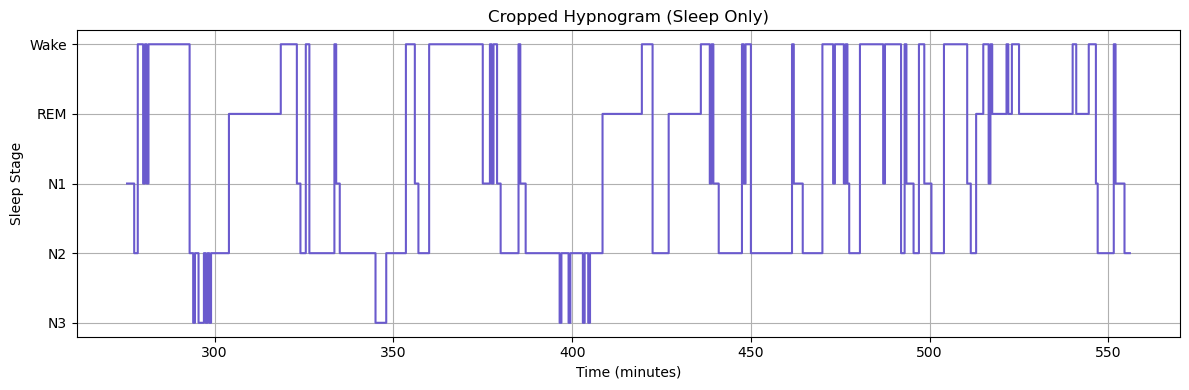

In [4]:
# --- Crop to sleep part ---
ids = np.where(np.isin(raw_stages, ['1', '2', '3', '4']))[0]
start = ids[0]
end = ids[-1] + 1

# Convert raw stages to numeric for slicing and plotting
night_sleep_stages = np.array(sleep_stages).astype(int)
night_sleep_stages = night_sleep_stages[start:end]
time_axis = np.arange(start, end) * epoch_size_sec / 60  # minutes

# --- Remap stages for plotting ---
plot_order = {0: 0, 4: 1, 1: 2, 2: 3, 3: 4}
plot_labels = ["Wake", "REM", "N1", "N2", "N3"]
plot_stages = np.array([plot_order.get(s, np.nan) for s in night_sleep_stages])

# --- Plot ---
plt.figure(figsize=(12, 4))
plt.plot(time_axis, plot_stages, drawstyle='steps-post', color='slateblue')
plt.gca().invert_yaxis()
plt.yticks(list(plot_order.values()), plot_labels)
plt.xlabel("Time (minutes)")
plt.ylabel("Sleep Stage")
plt.title("Cropped Hypnogram (Sleep Only)")
plt.grid(True)
plt.tight_layout()
plt.show()

## 2. Look at events 

In [5]:
events = info_dict['CMPStudyConfig']['ScoredEvents']['ScoredEvent']
if events is None:
    df_event = pd.DataFrame(data={
        'onset': [], 'duration': [], 'event_type': [],
        'channel': [], 'lowest_spo2': [], 'desaturation': []
    })
else:
    if not isinstance(events, list):
        events = [events]
    df_events = pd.DataFrame(events)

    # Convert column names to lowercase for consistent processing
    df_events.columns = [col.lower() for col in df_events.columns]

    # Rename columns to match BIDS-style event.csv
    df_events = df_events.rename(columns={
        'start': 'onset',
        'name': 'event_type',
        'input': 'channel',
        'lowestspo2': 'lowest_spo2'
    })

    # Ensure correct types
    df_events['onset'] = df_events['onset'].astype(float)
    df_events['duration'] = df_events['duration'].astype(float)
    df_events['event_type'] = df_events['event_type'].astype(str)
    df_events['channel'] = df_events['channel'].astype(str)

    # Harmonize string columns 
    df_events['event_type'] = df_events['event_type'].str.lower().str.replace(' ', '_')
    df_events['channel'] = df_events['channel'].str.lower().str.replace(' ', '_') 

    # Add Haoqi changes
    df_events.loc[df_events.event_type=='hypopnea','event_type'] = 'hypopnea_(airflow_reduction30-50%)'
    df_events.loc[df_events.event_type=='unsure','event_type'] = 'hypopnea_(airflow_reduction>50%)'

    # Sort and reorder columns
    df_events = df_events.sort_values('onset', ignore_index=True, ascending=True)
    df_events = df_events[['onset', 'duration', 'event_type', 'channel', 'lowest_spo2', 'desaturation']]

print(df_events['event_type'].value_counts(dropna=False))
print(df_events['channel'].value_counts(dropna=False))
df_events.head()

event_type
spo2_desaturation                     317
spo2_artifact                          86
arousal_(asda)                         78
hypopnea_(airflow_reduction30-50%)     23
hypopnea_(airflow_reduction>50%)       20
obstructive_apnea                       1
Name: count, dtype: int64
channel
spo2    403
c4       78
sum      44
Name: count, dtype: int64


,onset,duration,event_type,channel,lowest_spo2,desaturation
0,105.0,42.0,spo2_artifact,spo2,NaN,NaN
1,201.0,32.0,spo2_artifact,spo2,NaN,NaN
2,254.0,13.0,spo2_desaturation,spo2,94,2
3,289.0,19.0,spo2_artifact,spo2,NaN,NaN
4,386.0,5.0,spo2_artifact,spo2,NaN,NaN


In [6]:
# Align columns in both DataFrames
df_stages = df_stages.assign(event_type=np.nan, channel=np.nan, lowest_spo2=np.nan, desaturation=np.nan)
df_events = df_events.assign(sleep_stage=np.nan)

# Concatenate and sort by onset
df_events = pd.concat([df_stages, df_events], ignore_index=True).sort_values('onset').reset_index(drop=True)

df_events.head()

,onset,duration,sleep_stage,event_type,channel,lowest_spo2,desaturation
0,0.0,30.0,0.0,NaN,NaN,NaN,NaN
1,30.0,30.0,0.0,NaN,NaN,NaN,NaN
2,60.0,30.0,0.0,NaN,NaN,NaN,NaN
3,90.0,30.0,0.0,NaN,NaN,NaN,NaN
4,105.0,42.0,NaN,spo2_artifact,spo2,NaN,NaN


## Deduce read_annot file

In [7]:
import xmltodict
import numpy as np
import pandas as pd

def read_annot(row):

    # Open and read xml 
    annot_path = row["annot_path"]
    with open(annot_path, encoding='utf-8') as f:
            info_dict = xmltodict.parse(f.read())

    # Read and map sleep stage to match AASM guidelines  
    raw_stages = info_dict['CMPStudyConfig']['SleepStages']['SleepStage']
    stage_dict = {'0':0, '1':1, '2':2, '3':3, '4':3, '5':4}  
    full_sleep_stages = [stage_dict.get(str(s), np.nan) for s in raw_stages]

    # Create a df_stages
    duration_sec = row["duration_sec"]
    epoch_size_sec = float(info_dict['CMPStudyConfig']['EpochLength'])
    n_epochs = int(duration_sec / epoch_size_sec)

    if len(full_sleep_stages) != n_epochs:
        print(f"⚠️ Length mismatch: len(sleep_stages) = {len(full_sleep_stages)}")
        if len(full_sleep_stages) > n_epochs:
            print(f"Trimming extra sleep_stages: {full_sleep_stages[n_epochs:]}")
            full_sleep_stages = full_sleep_stages[:n_epochs]
        else:
            raise ValueError(f"sleep_stages is too short ({len(full_sleep_stages)}) for {n_epochs} epochs.")
        
    df_stages = pd.DataFrame({
        'onset': np.arange(0, n_epochs * 30, 30),
        'duration': np.full(n_epochs, 30),
        'sleep_stage': full_sleep_stages 
    })

    # Read events and add sleep stages
    events = info_dict['CMPStudyConfig']['ScoredEvents']['ScoredEvent']
    if events is None:
        df_events = pd.DataFrame(data={
            'onset': [], 'duration': [], 'event_type': [],
            'channel': [], 'lowest_spo2': [], 'desaturation': []
        })
    else:
        if not isinstance(events, list):
            events = [events]
        df_events = pd.DataFrame(events)

        # Convert column names to lowercase for consistent processing
        df_events.columns = [col.lower() for col in df_events.columns]

        # Rename columns to match BIDS-style event.csv
        df_events = df_events.rename(columns={
            'start': 'onset',
            'name': 'event_type',
            'input': 'channel',
            'lowestspo2': 'lowest_spo2'
        })

        # Ensure correct types
        df_events['onset'] = df_events['onset'].astype(float)
        df_events['duration'] = df_events['duration'].astype(float)
        df_events['event_type'] = df_events['event_type'].astype(str)
        df_events['channel'] = df_events['channel'].astype(str)

        # Harmonize string columns 
        df_events['event_type'] = df_events['event_type'].str.lower().str.replace(' ', '_')
        df_events['channel'] = df_events['channel'].str.lower().str.replace(' ', '_') 

        # Add Haoqi changes
        df_events.loc[df_events.event_type=='hypopnea','event_type'] = 'hypopnea_(airflow_reduction30-50%)'
        df_events.loc[df_events.event_type=='unsure','event_type'] = 'hypopnea_(airflow_reduction>50%)'

        # Sort and reorder columns
        df_events = df_events.sort_values('onset', ignore_index=True, ascending=True)
        df_events = df_events[['onset', 'duration', 'event_type', 'channel', 'lowest_spo2', 'desaturation']]
    
    # Align columns in both DataFrames
    df_stages = df_stages.assign(event_type=np.nan, channel=np.nan, lowest_spo2=np.nan, desaturation=np.nan)
    df_events = df_events.assign(sleep_stage=np.nan)

    # Concatenate and sort by onset
    df_events = pd.concat([df_stages, df_events], ignore_index=True).sort_values('onset').reset_index(drop=True)

    return sleep_stages, df_events

mastersheet_path = "/Users/alicealbrecht/Desktop/UCSF/pipeline_project/datasets/mastersheets/mros_ses02_mastersheet.csv"
mastersheet = pd.read_csv(mastersheet_path)
row = mastersheet.iloc[1]
sleep_stages, df_events = read_annot(row)
df_events

,onset,duration,sleep_stage,event_type,channel,lowest_spo2,desaturation
0,0.0,30.0,0.0,NaN,NaN,NaN,NaN
1,30.0,30.0,0.0,NaN,NaN,NaN,NaN
2,60.0,30.0,0.0,NaN,NaN,NaN,NaN
3,90.0,30.0,0.0,NaN,NaN,NaN,NaN
4,105.0,42.0,NaN,spo2_artifact,spo2,NaN,NaN
...,...,...,...,...,...,...,...
2350,54750.0,30.0,0.0,NaN,NaN,NaN,NaN
2351,54780.0,30.0,0.0,NaN,NaN,NaN,NaN
2352,54810.0,30.0,0.0,NaN,NaN,NaN,NaN
2353,54840.0,30.0,0.0,NaN,NaN,NaN,NaN


In [29]:
import h5py
from datetime import datetime, timedelta

h5_path = row["h5_path"]

with h5py.File(h5_path, 'r') as f:
    full_ecg = f['signals/ECG/ECG'][:]
    sfreq_ecg = f['signals/ECG/ECG'].attrs['fs']
    
# Keep only sleep
sleep_epoch_ids = np.where(np.isin(raw_stages, ['1', '2', '3', '4']))[0]
start_epoch = sleep_epoch_ids[0]
end_epoch = sleep_epoch_ids[-1] + 1  # include last one

# Cut sleep stages and ecg
sleep_stages = full_sleep_stages[start_epoch:end_epoch]
start_sample = start_epoch * epoch_size_sec * sfreq_ecg
end_sample   = end_epoch * epoch_size_sec * sfreq_ecg  # no +30 needed!
ecg = full_ecg[int(start_sample):int(end_sample)]

# Adjust the sleep time 
sleep_onset_epoch = sleep_epoch_ids[0]
sleep_onset_offset_sec = sleep_onset_epoch * epoch_size_sec
start_time = row["start_time"]
start_time = datetime.fromisoformat(start_time)
print(type(start_time))
sleep_onset_time = start_time + timedelta(seconds=sleep_onset_offset_sec)
print(f"Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Sleep onset time: {sleep_onset_time.strftime('%Y-%m-%d %H:%M:%S')}")

<class 'datetime.datetime'>
Start time: 2011-07-06 20:38:46
🛏️ Sleep onset time: 2011-07-07 01:14:16


In [ ]:
with h5py.File(h5_path, 'r') as f:
        full_ecg = f['signals/ECG/ECG'][:]
        sfreq_ecg = f['signals/ECG/ECG'].attrs['fs']
        
epoch_length_sec = epoch_size_sec

def take_sleep_part(full_ecg, sfreq_ecg, full_sleep_stages, epoch_length_sec):

    # Keep only sleep
    sleep_epoch_ids = np.where(np.isin(raw_stages, ['1', '2', '3', '4']))[0]
    start_epoch = sleep_epoch_ids[0]
    end_epoch = sleep_epoch_ids[-1] + 1  # include last one

    # Cut sleep stages and ecg
    sleep_stages = full_sleep_stages[start_epoch:end_epoch]
    start_sample = start_epoch * epoch_length_sec * sfreq_ecg
    end_sample   = end_epoch * epoch_length_sec * sfreq_ecg  # no +30 needed!
    ecg = full_ecg[int(start_sample):int(end_sample)]

    # Adjust the sleep time 
    sleep_onset_epoch = sleep_epoch_ids[0]
    sleep_onset_offset_sec = sleep_onset_epoch * epoch_size_sec
    start_time = datetime.fromisoformat(row["start_time"])
    sleep_onset_time = start_time + timedelta(seconds=sleep_onset_offset_sec)

    return ecg, sleep_stages, sleep_onset_time